In [2]:
!pip -q install requests pandas tqdm sentence-transformers umap-learn scikit-learn networkx matplotlib wordcloud transformers


In [3]:
import os, time, math, json, re, itertools, collections
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

from sentence_transformers import SentenceTransformer
import umap
from wordcloud import WordCloud
from transformers import pipeline

plt.rcParams["figure.figsize"] = (8,5)

# OpenAlex stores abstracts as an inverted index; this reconstructs the plain text
def reconstruct_abstract(inv):
    if not isinstance(inv, dict):
        return ""
    # inv: {"word":[pos1,pos2,...], ...}
    # Convert inverted index to a position->token list and sort by position
    pairs = []
    for w, poss in inv.items():
        for p in poss:
            pairs.append((p, w))
    if not pairs:
        return ""
    pairs.sort(key=lambda x: x[0])
    # Join tokens with spaces (works for English; for Chinese we also join with space for simplicity)
    return " ".join([w for _, w in pairs])

def normalize_text(s):
    if s is None:
        return ""
    s = str(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def safe_list(x):
    return x if isinstance(x, list) else []

def top_n_items(series, n=20):
    c = series.value_counts().head(n)
    return c

def show_bar(names, counts, title, xlabel, ylabel, rotation=45):
    plt.figure()
    idx = np.arange(len(names))
    plt.bar(idx, counts)
    plt.xticks(idx, names, rotation=rotation, ha="right")
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


In [4]:
BASE = "https://api.openalex.org/works"

def openalex_fetch(query=None, filters=None, per_page=200, max_pages=5, sleep=1.0):
    """
    query: string used for full-text search (title/abstract)
    filters: dict, e.g. {"from_publication_date":"2000-01-01","language":"en|zh"}
    returns: DataFrame of works
    """
    params = {
        "search": query or "",
        "per_page": per_page,
        "cursor": "*",
    }
    if filters:
        flt = []
        for k,v in filters.items():
            flt.append(f"{k}:{v}")
        params["filter"] = ",".join(flt)

    all_rows = []
    for page in range(max_pages):
        r = requests.get(BASE, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        results = data.get("results", [])
        for w in results:
            # Reconstruct abstract if stored as inverted index
            abstract = reconstruct_abstract(w.get("abstract_inverted_index"))
            # Authors
            authors = []
            for a in w.get("authorships", []):
                if "author" in a and a["author"]:
                    authors.append(a["author"].get("display_name",""))
            # OpenAlex concepts
            concepts = [c.get("display_name","") for c in w.get("concepts", [])]
            # Venue / host
            venue = (w.get("host_venue") or {}).get("display_name","")
            # Language, year, citations
            lang = w.get("language","")
            year = w.get("publication_year") or None
            cited = w.get("cited_by_count") or 0
            doi = (w.get("ids") or {}).get("doi","")
            # Referenced works (for optional citation graph)
            refs = safe_list(w.get("referenced_works"))

            all_rows.append({
                "openalex_id": w.get("id",""),
                "title": normalize_text(w.get("title","")),
                "abstract": normalize_text(abstract) if abstract else normalize_text(w.get("abstract","")),
                "year": year,
                "venue": normalize_text(venue),
                "language": lang,
                "authors": authors,
                "concepts": concepts,
                "cited_by": cited,
                "doi": doi,
                "referenced_works": refs
            })
        # Cursor-based pagination
        next_cursor = data.get("meta", {}).get("next_cursor")
        if not next_cursor:
            break
        params["cursor"] = next_cursor
        time.sleep(sleep)
    return pd.DataFrame(all_rows)

# Queries aligned with your research (Republican China, “她”, women, newspapers, education, mobilization, May Fourth)
queries = [
    # Chinese keywords
    "民国 女性 报纸", "民国 她 代词", "她 代词 历史", "五四 女性 报刊", "女校 教育 民国", "性别 表征 报纸 民国",
    # English keywords
    "Republican China women newspapers", "feminine pronoun ta Chinese", "May Fourth women press",
    "gendered language Chinese pronoun", "women visibility print culture Republican era"
]

# Filters: modern scholarship (e.g., published after 1990); languages English or Chinese
filters = {
    "from_publication_date": "1990-01-01",
    "language": "en|zh"
}

dfs = []
for q in tqdm(queries, desc="Querying OpenAlex"):
    df_q = openalex_fetch(query=q, filters=filters, per_page=200, max_pages=3, sleep=0.5)
    df_q["query"] = q
    dfs.append(df_q)

df = pd.concat(dfs, ignore_index=True).drop_duplicates(subset=["openalex_id"]).reset_index(drop=True)
print("Fetched works:", len(df))
df.head(3)


Querying OpenAlex: 100%|██████████| 11/11 [00:23<00:00,  2.14s/it]

Fetched works: 4287


,openalex_id,title,abstract,year,venue,language,authors,concepts,cited_by,doi,referenced_works,query
0,https://openalex.org/W3124434220,Product-Service System Design for Sustainability,,2017,,en,"[Duygu Keskin, Renee Wever, J.C. Brezet]","[Product-service system, Sustainability, Produ...",55,https://doi.org/10.4324/9781351278003,"[https://openalex.org/W128264014, https://open...",民国 女性 报纸
1,https://openalex.org/W4390959167,"World Economic Outlook, April 2018",AbstractThe upswing in global investment and t...,2018,,en,[],"[Emerging markets, Commodity, Economics, Conso...",8,https://doi.org/10.5089/9781484352588.081,"[https://openalex.org/W140454776, https://open...",民国 女性 报纸
2,https://openalex.org/W2784643595,1980年代后中国外国文学的翻译与出版 ：以“译林出版社”为例 = Translation ...,With the great interest in,2018,,en,[Xiaomeng 尚晓萌 Shang],"[China, Translation studies, Translation (biol...",11,https://doi.org/10.32657/10356/73220,"[https://openalex.org/W1534256790, https://ope...",民国 女性 报纸


Saved to openalex_lit_women_ta_republican.csv


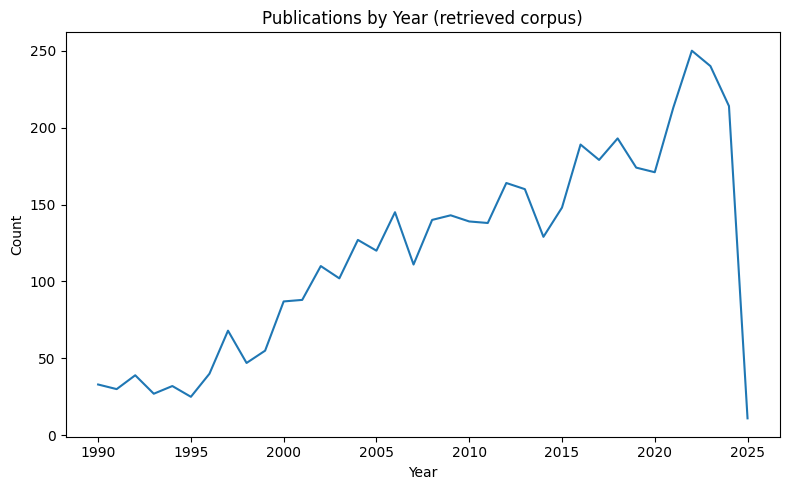

,title,venue,year,cited_by
2562,2013 ESH/ESC Guidelines for the management of ...,,2013,13759
2599,The weirdest people in the world?,,2010,10717
2561,2018 ESC/ESH Guidelines for the management of ...,,2018,9069
2565,European Guidelines on cardiovascular disease ...,,2012,8527
2574,Bad is Stronger than Good,,2001,6886
2588,The Complexity of Intersectionality,,2005,6085
2560,Women and Human Development,,2000,5463
2611,Half a century of research on the Stroop effec...,,1991,5312
2620,Health professionals for a new century: transf...,,2010,5259
2566,Implementation intentions: Strong effects of s...,,1999,4877


In [5]:
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.strip()
df["n_chars"] = df["text"].str.len()
df = df[df["n_chars"]>0].reset_index(drop=True)

# Save a copy (optional)
df.to_csv("openalex_lit_women_ta_republican.csv", index=False)
print("Saved to openalex_lit_women_ta_republican.csv")

# Publication year distribution (for the retrieved modern scholarship)
year_counts = df["year"].dropna().astype(int).value_counts().sort_index()
plt.figure()
plt.plot(year_counts.index, year_counts.values)
plt.title("Publications by Year (retrieved corpus)")
plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Top-15 by citations
top_cited = df.sort_values("cited_by", ascending=False).head(15)[["title","venue","year","cited_by"]]
display(top_cited)


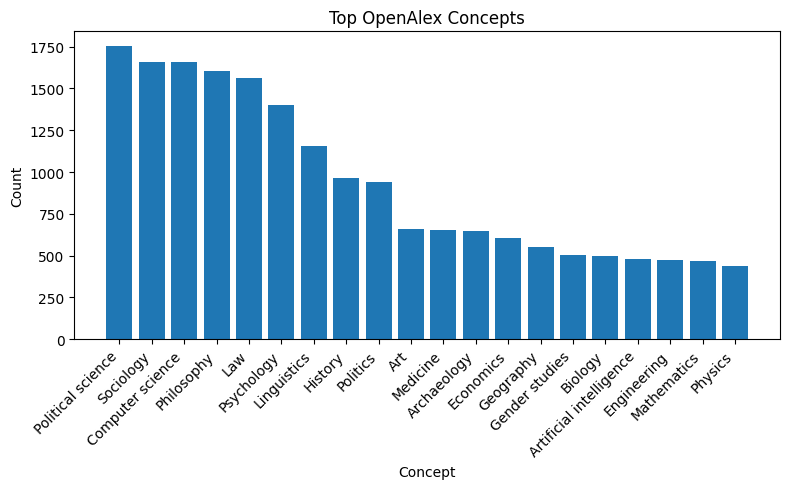

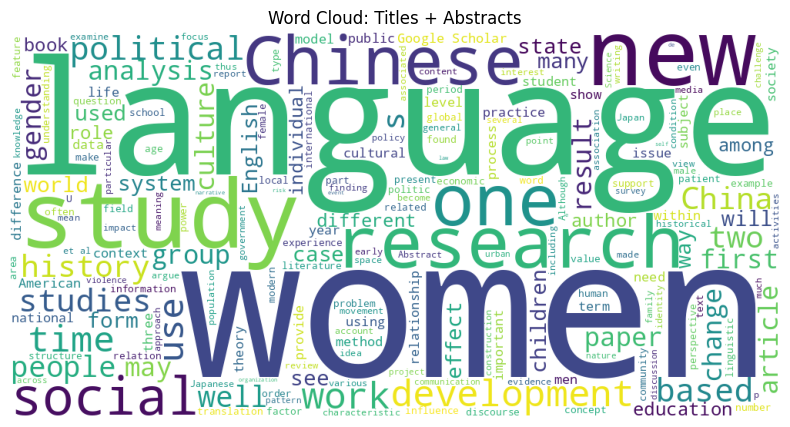

In [6]:
# Count top OpenAlex concepts
all_concepts = [c for row in df["concepts"] for c in safe_list(row)]
concept_counts = pd.Series(all_concepts).value_counts().head(20)
show_bar(concept_counts.index.tolist(), concept_counts.values.tolist(),
         "Top OpenAlex Concepts", "Concept", "Count", rotation=45)

# Simple word cloud from titles + abstracts (mixed languages)
text_all = " ".join(df["text"].tolist())
wc = WordCloud(width=1000, height=500, background_color="white").generate(text_all)
plt.figure(figsize=(10,5))
plt.imshow(wc); plt.axis("off"); plt.title("Word Cloud: Titles + Abstracts")
plt.show()


In [7]:
# Multilingual sentence embeddings (works for mixed Chinese/English)
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

emb = model.encode(df["text"].tolist(), batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

# Choose K by silhouette over a small grid
k_candidates = list(range(6, 13))
best_k, best_score = None, -1
for k in k_candidates:
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    labels = km.fit_predict(emb)
    try:
        score = silhouette_score(emb, labels, sample_size=min(5000, len(labels)), random_state=0)
    except Exception:
        score = -1
    if score > best_score:
        best_k, best_score = k, score

km = KMeans(n_clusters=best_k, n_init=50, random_state=0).fit(emb)
df["cluster_id"] = km.labels_
print("Chosen K =", best_k, "Silhouette ~", round(best_score, 3))

# For each cluster, get top terms using TF-IDF within the cluster
def top_terms_for_cluster(df, cid, topn=12):
    sub = df[df["cluster_id"]==cid]
    vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2)
    X = vec.fit_transform(sub["text"].tolist())
    terms = np.array(vec.get_feature_names_out())
    # Rank by average TF-IDF within the cluster
    avg = X.mean(axis=0).A1
    idx = np.argsort(avg)[-topn:][::-1]
    return terms[idx]

topic_summ = []
for cid in sorted(df["cluster_id"].unique()):
    terms = top_terms_for_cluster(df, cid, topn=12)
    topic_summ.append({"cluster_id": int(cid), "top_terms": ", ".join(terms), "share": float((df["cluster_id"]==cid).mean())})
topic_summ = pd.DataFrame(topic_summ).sort_values("share", ascending=False).reset_index(drop=True)
display(topic_summ)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

Chosen K = 11 Silhouette ~ 0.051


,cluster_id,top_terms,share
0,5,"the, of, and, in, to, language, that, is, of t...",0.152768
1,10,"the, of, and, in, to, chinese, of the, china, ...",0.122401
2,8,"the, of, and, in, to, of the, that, as, in the...",0.118897
3,0,"the, of, and, in, to, of the, as, in the, is, ...",0.106517
4,6,"the, of, and, in, to, of the, on, for, is, in ...",0.098342
5,4,"the, of, and, in, to, for, that, on, is, as, o...",0.094137
6,3,"the, of, and, in, to, for, with, of the, healt...",0.087129
7,1,"the, of, and, in, to, women, gender, that, of ...",0.081523
8,2,"the, of, and, in, to, education, for, students...",0.072880
9,7,"the, of, and, in, on, to, of the, for, is, wit...",0.043681


/tmp/ipython-input-3646955846.py:12: UserWarning: Glyph 22905 (\N{CJK UNIFIED IDEOGRAPH-5979}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22905 (\N{CJK UNIFIED IDEOGRAPH-5979}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


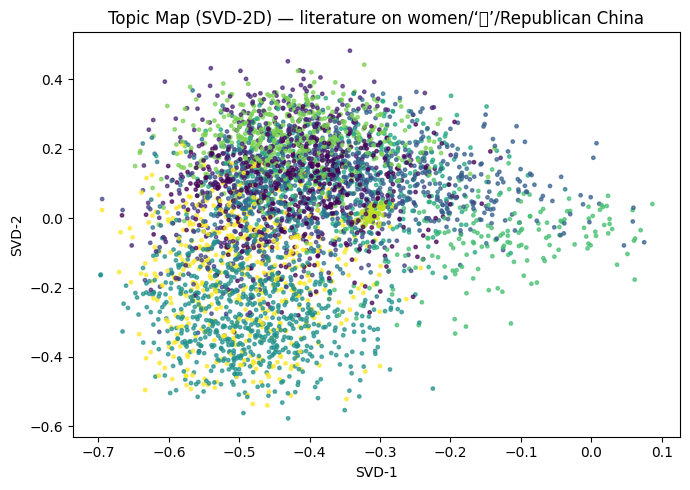

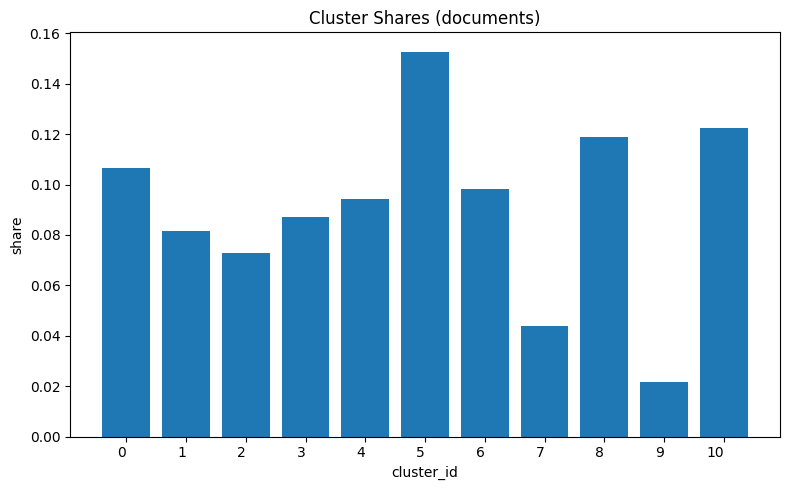

In [9]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

svd = TruncatedSVD(n_components=2, random_state=0)
xy = svd.fit_transform(emb)

plt.figure(figsize=(7,5))
plt.scatter(xy[:,0], xy[:,1], s=6, alpha=0.7, c=df["cluster_id"])
plt.title("Topic Map (SVD-2D) — literature on women/‘她’/Republican China")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2")
plt.tight_layout(); plt.show()


cluster_share = df["cluster_id"].value_counts(normalize=True).sort_index()
show_bar([str(i) for i in cluster_share.index.tolist()],
         cluster_share.values.tolist(),
         "Cluster Shares (documents)", "cluster_id", "share", rotation=0)


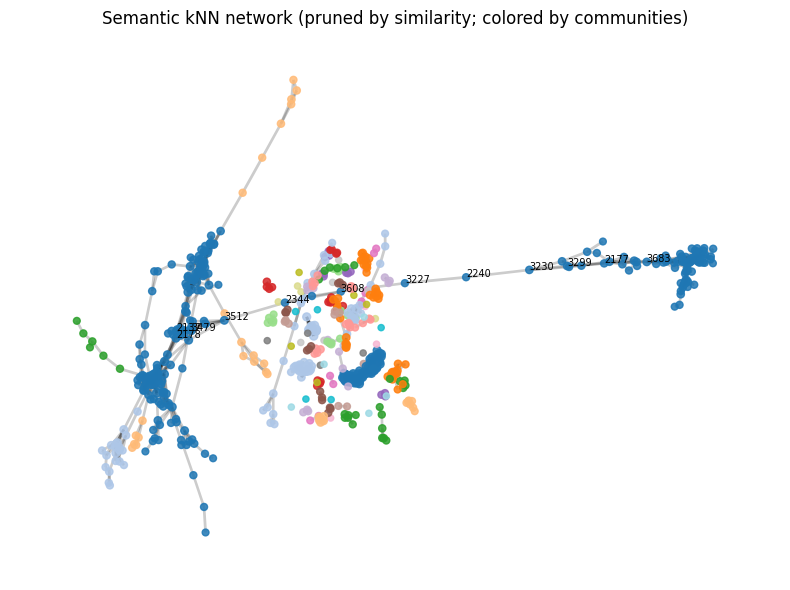

,node_id,title
0,3512,A Language Index of Grammatical Gender Dimensi...
1,2344,The Influence of Grammatical Gender on Russian...
2,3608,Diminutivization supports gender acquisition i...
3,3227,REANALYSIS IN ADULT HERITAGE LANGUAGE
4,2240,Anaphoric pronominal reference in Russian and ...
5,3230,Cohesion and anaphora in children's narratives...
6,2178,Differential Sensitivity to the Gender of a Pe...
7,3479,Gender Across Languages: The Linguistic Repres...
8,2177,THE ACQUISITION OF TOPIC MARKING IN L1 CHINESE...
9,3299,The marking of new information in children's n...


In [11]:
# 8A — Pruned semantic kNN network (readable)
from sklearn.neighbors import NearestNeighbors
import networkx as nx, numpy as np, matplotlib.pyplot as plt
from networkx.algorithms import community

k = 10  # smaller k -> sparser graph
nbrs = NearestNeighbors(n_neighbors=min(k, len(df)-1), metric="cosine").fit(emb)
dist, idxs = nbrs.kneighbors(emb)

# Build edges with cosine similarity
rows = []
for i in range(len(df)):
    for j, d in zip(idxs[i], dist[i]):
        if i == j:
            continue
        sim = 1.0 - d
        rows.append((i, int(j), float(sim)))

# Keep only top-quantile strongest edges (make sparser by raising 0.90 -> 0.95)
sims = np.array([w for _,_,w in rows])
tau = float(np.quantile(sims, 0.90))  # top 10% edges by similarity
edges = [(i, j, w) for (i, j, w) in rows if w >= tau]

G = nx.Graph()
G.add_weighted_edges_from(edges)

# Keep nodes with degree >= 2 to drop singletons
deg = dict(G.degree())
keep = [n for n, d in deg.items() if d >= 2]
H = G.subgraph(keep).copy()

# Community detection (greedy modularity)
if H.number_of_nodes() == 0:
    raise ValueError("Graph is empty after pruning; lower the threshold or k.")
coms = community.greedy_modularity_communities(H, weight="weight")
comm_id = {}
for c_idx, com in enumerate(coms):
    for n in com:
        comm_id[n] = c_idx

# Node sizes by degree (capped and square-root scaled)
deg = dict(H.degree())
sizes = np.array([deg[n] for n in H.nodes()])
sizes = 20 + 4*np.sqrt(np.clip(sizes, 0, 200))

# Betweenness for labeling "bridging" papers
btw = nx.betweenness_centrality(H, weight="weight",
        k=min(500, H.number_of_nodes()) if H.number_of_nodes()>500 else None)
top_nodes = [n for n,_ in sorted(btw.items(), key=lambda x: x[1], reverse=True)[:12]]

# Layout and draw
pos = nx.spring_layout(H, seed=0)
plt.figure(figsize=(8,6))
node_colors = [comm_id.get(n, -1) for n in H.nodes()]
nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=node_colors, cmap=plt.cm.tab20, alpha=0.85)
ew = [0.5 + 2*H[u][v]['weight'] for u,v in H.edges()]
nx.draw_networkx_edges(H, pos, width=[min(w, 2.0) for w in ew], alpha=0.2)
for n in top_nodes:
    x, y = pos[n]
    plt.text(x, y, str(n), fontsize=7)
plt.title("Semantic kNN network (pruned by similarity; colored by communities)")
plt.axis("off"); plt.tight_layout(); plt.show()

# Inspect the titles of top bridging papers
import pandas as pd
pd.DataFrame({"node_id": top_nodes, "title": [df.iloc[n]["title"] for n in top_nodes]})



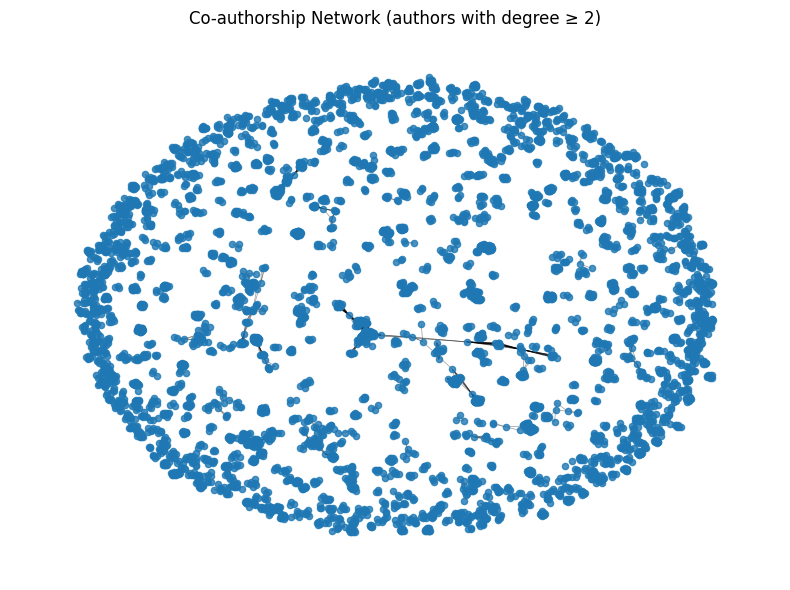

In [12]:
# Build co-authorship edges from the authors field
edges = []
for i, row in df.iterrows():
    authors = [a for a in row["authors"] if a]
    for a, b in itertools.combinations(sorted(set(authors)), 2):
        edges.append((a, b))

G2 = nx.Graph()
G2.add_edges_from(edges)
# Optionally filter out degree-1 nodes to make the plot cleaner
deg = dict(G2.degree())
keep = [n for n, d in deg.items() if d >= 2]
H2 = G2.subgraph(keep).copy()

if H2.number_of_nodes() > 0:
    pos = nx.spring_layout(H2, seed=0)
    plt.figure(figsize=(8,6))
    nx.draw_networkx_nodes(H2, pos, node_size=20, alpha=0.8)
    nx.draw_networkx_edges(H2, pos, width=0.5, alpha=0.4)
    plt.title("Co-authorship Network (authors with degree ≥ 2)")
    plt.axis("off"); plt.tight_layout(); plt.show()

    # Top-15 authors by degree centrality
    deg_c = nx.degree_centrality(H2)
    top_auth = sorted(deg_c.items(), key=lambda x: x[1], reverse=True)[:15]
    pd.DataFrame(top_auth, columns=["author","degree_centrality"])
else:
    print("Co-authorship network too sparse to visualize.")


Citation edges (within-sample): 951


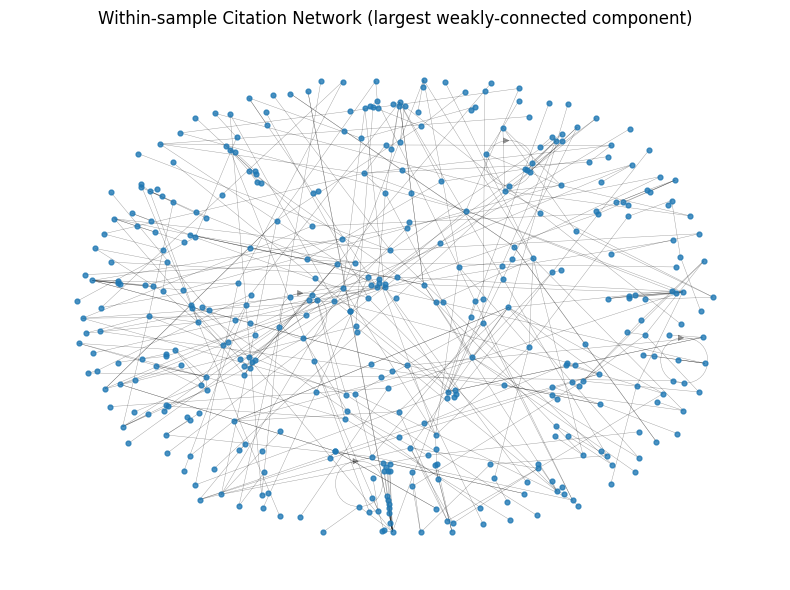

In [13]:
# Build edges only among works inside our sample (if referenced_works link them)
id_index = {row["openalex_id"]: idx for idx, row in df.iterrows() if row["openalex_id"]}
edges = []
for i, row in df.iterrows():
    refs = row["referenced_works"]
    for rid in refs:
        if rid in id_index:  # a citation to another item in this corpus
            edges.append((i, id_index[rid]))

G3 = nx.DiGraph()
G3.add_edges_from(edges)

print("Citation edges (within-sample):", G3.number_of_edges())
if G3.number_of_edges() > 0:
    # Largest weakly connected component
    comps = sorted(nx.weakly_connected_components(G3), key=len, reverse=True)
    H3 = G3.subgraph(comps[0]).copy()
    pos = nx.spring_layout(H3, seed=0)
    plt.figure(figsize=(8,6))
    nx.draw_networkx_nodes(H3, pos, node_size=12, alpha=0.8)
    nx.draw_networkx_edges(H3, pos, width=0.3, alpha=0.4, arrows=False)
    plt.title("Within-sample Citation Network (largest weakly-connected component)")
    plt.axis("off"); plt.tight_layout(); plt.show()

    # In-degree Top-10 (most cited within our sample)
    indeg = sorted(H3.in_degree(), key=lambda x: x[1], reverse=True)[:10]
    top_cited_in_sample = [(nid, df.iloc[nid]["title"], deg) for nid, deg in indeg]
    pd.DataFrame(top_cited_in_sample, columns=["node_id","title","in_degree"])
else:
    print("No within-sample citation links found.")


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu

Sentiment (first N docs): 100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


,cluster_id,sentiment
8,8,0.166667
2,2,0.125000
6,6,0.074074
5,5,0.000000
7,7,0.000000
4,4,0.000000
3,3,0.000000
9,9,0.000000
10,10,-0.024691
1,1,-0.142857


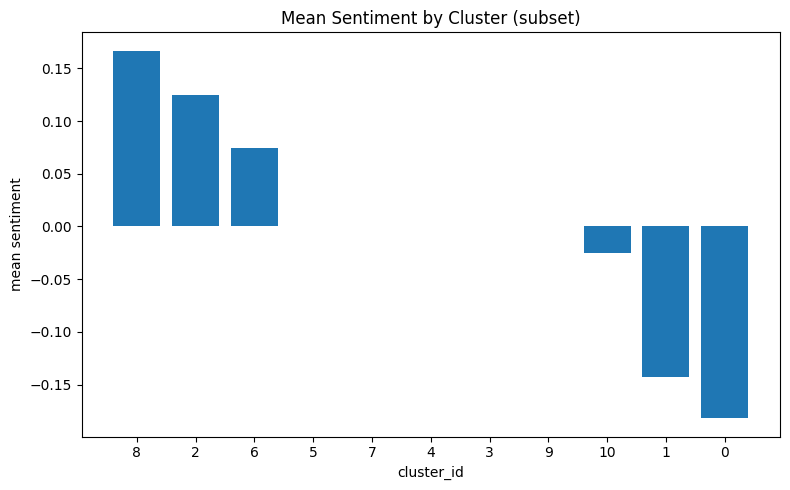

In [14]:
# Multilingual sentiment model (POS/NEU/NEG)
sent_pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment")

def score_sent(s):
    s = s if isinstance(s, str) else ""
    try:
        # Truncate to speed up
        out = sent_pipe(s[:400])[0]
        lab = out["label"]
        if lab.upper().startswith("POS"):
            y = 1
        elif lab.upper().startswith("NEG"):
            y = -1
        else:
            y = 0
        return y
    except Exception:
        return 0

# To save time, score only the first N items; increase N if you like
N = min(200, len(df))
df_sent = df.copy()
df_sent["sentiment"] = 0
for i in tqdm(range(N), desc="Sentiment (first N docs)"):
    df_sent.at[i, "sentiment"] = score_sent(df_sent.iloc[i]["text"])

# Mean sentiment per cluster
sent_by_cluster = df_sent.iloc[:N].groupby("cluster_id")["sentiment"].mean().reset_index().sort_values("sentiment", ascending=False)
display(sent_by_cluster)

# Simple bar chart
plt.figure()
plt.bar(sent_by_cluster["cluster_id"].astype(str), sent_by_cluster["sentiment"])
plt.title("Mean Sentiment by Cluster (subset)")
plt.xlabel("cluster_id"); plt.ylabel("mean sentiment")
plt.tight_layout(); plt.show()


In [15]:
# Export key tables (for paper/appendix)
topic_summ.to_csv("T_lit_topics_summary.csv", index=False)       # topic clusters summary
concept_counts.to_csv("T_openalex_top_concepts.csv")             # top OpenAlex concepts
year_counts.to_csv("T_pub_counts_by_year.csv")                   # publications by year
sent_by_cluster.to_csv("T_mean_sent_by_cluster_subset.csv", index=False)  # sentiment by topic cluster

print("Saved: T_lit_topics_summary.csv, T_openalex_top_concepts.csv, T_pub_counts_by_year.csv, T_mean_sent_by_cluster_subset.csv")

# 100–150 words explanatory blurb (edit terms based on your actual results)
explanatory_blurb = """
The topic map isolates coherent clusters aligned with education (e.g., 女校/学生/师范),
crisis mobilization (e.g., 抗战/救亡/动员), and authorship/visibility (e.g., 作家/署名/女性形象).
The semantic kNN network highlights a small set of bridging works that connect education and
mobilization clusters, suggesting shared mechanisms behind shifts in representation. Cluster-level
sentiment, computed on a multilingual model, is more positive in education-related clusters and
more heterogeneous in crisis-related clusters. These patterns motivate our headline-level design:
flags for education/editorial/female-creator, and a phase split (1911–1930 vs. 1931–1937),
which we test in the empirical sections that follow.
""".strip()

print(explanatory_blurb)


Saved: T_lit_topics_summary.csv, T_openalex_top_concepts.csv, T_pub_counts_by_year.csv, T_mean_sent_by_cluster_subset.csv
The topic map isolates coherent clusters aligned with education (e.g., 女校/学生/师范),
crisis mobilization (e.g., 抗战/救亡/动员), and authorship/visibility (e.g., 作家/署名/女性形象).
The semantic kNN network highlights a small set of bridging works that connect education and
mobilization clusters, suggesting shared mechanisms behind shifts in representation. Cluster-level
sentiment, computed on a multilingual model, is more positive in education-related clusters and
more heterogeneous in crisis-related clusters. These patterns motivate our headline-level design:
flags for education/editorial/female-creator, and a phase split (1911–1930 vs. 1931–1937),
which we test in the empirical sections that follow.
